# COVID-19 Prediction Model for Maryland

## Part 2 - Baseline Model

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob

from bokeh.models import NumeralTickFormatter, DatetimeTickFormatter, ColumnDataSource, HoverTool, CrosshairTool, SaveTool, PanTool, Range1d
from bokeh.plotting import figure, show, output_file
from bokeh.models import Line,TapTool
from bokeh.io import output_notebook, show
output_notebook()

import os

from multiprocessing import Pool

import xgboost as xgb
from xgboost import plot_importance

from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import r2_score

Loading BokehJS ...

### Import Data

The below loads JHU's Covid-19 data using multiprocessing and corrects for inconsistent formatting across the CSV files.

In [2]:
# load data in parallel

def read_csv(file):
    
    path = "COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/"
    
    tmp = pd.read_csv(path + file)
    
    # the various try code blocks correct for inconsistencies between subsequent data files.
    try:
        tmp['Province_State']
    except KeyError:
        tmp = tmp.rename(columns={'Province/State': 'Province_State', 'Country/Region': 'Country_Region', 'Last Update': 'Last_Update'})
        tmp['Admin2'] = np.NaN
        tmp['FIPS'] = np.NaN
        tmp = tmp.astype({'Admin2': 'str', 'FIPS': 'float64'})
    
    try:
        tmp['Lat']
    except KeyError:
        tmp = tmp.rename(columns={'Latitude': 'Lat', 'Longitude': 'Long_'})
        
    try:
        tmp['Incidence_Rate']
    except KeyError:
        tmp = tmp.rename(columns={'Incident_Rate': 'Incidence_Rate'})
    
    try:
        tmp['Case-Fatality_Ratio']
    except KeyError:
        tmp = tmp.rename(columns={'Case_Fatality_Ratio': 'Case-Fatality_Ratio'})
    
    
    # Retain only those rows associated with the US
    tmp = tmp[tmp['Country_Region'] == 'US']
    
    # Extract the date from the filename
    file_date = file[-14:-4]
    
    # Date for EDA
    tmp['Data_Date'] = file_date
    tmp['Data_Date'] = pd.to_datetime(tmp['Data_Date'])
    
    # Date_Block field for easier sorting
    tmp['Date_Block'] = int(str(file_date[6:])+str(file_date[0:2])+str(file_date[3:5])) # this adds the filename date as a new column
    
    return tmp


def parallel_load():

    granular_covid_data = pd.read_csv("COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/10-03-2020.csv")
    
    path = "COVID-19-master/csse_covid_19_data/csse_covid_19_daily_reports/"
    files = os.listdir(path)
    file_list = [filename for filename in files if filename.split('.')[1]=='csv']

    with Pool(processes=4) as pool:

        df_list = pool.map(read_csv, file_list)

        granular_covid_data = pd.concat(df_list, ignore_index=True)
    
    return granular_covid_data

In [3]:
granular_covid_data = parallel_load()
granular_covid_data = granular_covid_data.sort_values(by = ['Province_State', 'FIPS', 'Date_Block'])

In [4]:
# calculate new cases
granular_covid_data['New_Cases'] = granular_covid_data['Confirmed'].diff(periods = 1).fillna(0).clip(lower = 0)

In [5]:
# isolate Maryland data
md_granular = granular_covid_data[(granular_covid_data['Province_State'] == 'Maryland')]
md_granular = md_granular.dropna(subset=['Date_Block','FIPS']).reset_index().drop(['index'], axis=1)

In [6]:
md_granular = md_granular.dropna(subset=['Date_Block','FIPS', 'Lat']).reset_index().drop(['index'], axis=1) #this is to drop the unclassified FIPS

In [7]:
# generate target variable
md_granular['Cases_14_Days_Forward'] = md_granular.sort_values(['FIPS','Date_Block']).groupby(['FIPS'])['New_Cases'].shift(-14).fillna(0)

In [8]:
# This custom function allows us to plot XGBoost's training and validation performance

def xgb_perf(model_name, objective):
    d = {'boosting_round': np.arange(0, len(progress['train'][objective])), 'train': np.array(progress['train'][objective]), 'validation': np.array(progress['validation'][objective])}
    progress_df = pd.DataFrame(data = d)

    source = ColumnDataSource(progress_df)

    p = figure(plot_width=800, plot_height=400, tools="tap, wheel_zoom, save, pan, reset, box_zoom", title="XGBoost Performance - " + model_name)
    p.line('boosting_round', 'train', source = source, line_color = 'blue', line_width=2, legend_label = 'train')
    p.line('boosting_round', 'validation', source = source, line_color = 'orange', line_width=2, legend_label = 'validation')

    hover = HoverTool(tooltips=[('boosting round', '@boosting_round'), ("validation", "@validation{0,0.00}"), ("train", "@train{0,0.00}")], mode='mouse')
    hover.point_policy = 'follow_mouse'
    hover.line_policy='nearest'

    cross = CrosshairTool(dimensions = 'height')

    p.add_tools(hover)
    p.add_tools(cross)

    p.xaxis.axis_label = 'Boosting Round'
    p.yaxis.axis_label = objective
    p.legend.location = 'top_right'

    show(p)

In [9]:
baseline_data = md_granular.drop(['Admin2', 'Province_State', 'Country_Region', 'Last_Update', 'Data_Date', 'Lat', 'Long_', 'Recovered', 'Active', 'Combined_Key', 'Incidence_Rate', 'Case-Fatality_Ratio','Confirmed','Deaths'], axis = 1)
baseline_data = baseline_data.sort_values(by = ['FIPS', 'Date_Block'])

In [10]:
X_train = baseline_data[(baseline_data['Date_Block'] > 20200415) & (baseline_data['Date_Block'] <= 20220126)]
y_train = baseline_data[(baseline_data['Date_Block'] > 20200415) & (baseline_data['Date_Block'] <= 20220126)]['Cases_14_Days_Forward']

X_validation = baseline_data[(baseline_data['Date_Block'] > 20220126) & (baseline_data['Date_Block'] <= 20220127)]
y_validation = baseline_data[(baseline_data['Date_Block'] > 20220126) & (baseline_data['Date_Block'] <= 20220127)]['Cases_14_Days_Forward']

X_train = X_train.drop(['Cases_14_Days_Forward'], axis = 1)
X_validation = X_validation.drop(['Cases_14_Days_Forward'], axis = 1)

In [11]:
# a dateblock of Jan 28 here means we are making a prediction for February 11, which is 14 days forward.
X_test = baseline_data[(baseline_data['Date_Block'] == 20220128)]
y_test = baseline_data[(baseline_data['Date_Block'] == 20220128)]['Cases_14_Days_Forward']

X_test = X_test.drop(['Cases_14_Days_Forward'], axis = 1)

In [12]:
params = {
        'learning_rate': 0.3,
        'max_depth': 6,
        'subsample': 1,
        'colsample_bytree': 1, 
        'eval_metric': 'poisson-nloglik', 
        'objective': 'count:poisson',
        'seed': 42
    }

watchlist = [
    (xgb.DMatrix(X_train, y_train), 'train'),
    (xgb.DMatrix(X_validation, y_validation), 'validation')
]

progress = dict()

baseline_model = xgb.train(params, xgb.DMatrix(X_train, y_train), 1000000,  watchlist, maximize=False, verbose_eval=100, early_stopping_rounds=1000, evals_result = progress)

[0]	train-poisson-nloglik:305.05054	validation-poisson-nloglik:169.56395
[100]	train-poisson-nloglik:5.00880	validation-poisson-nloglik:7.06243
[200]	train-poisson-nloglik:4.23617	validation-poisson-nloglik:7.07670
[300]	train-poisson-nloglik:3.84086	validation-poisson-nloglik:7.07125
[400]	train-poisson-nloglik:3.57489	validation-poisson-nloglik:7.10930
[500]	train-poisson-nloglik:3.37875	validation-poisson-nloglik:7.24777
[600]	train-poisson-nloglik:3.21664	validation-poisson-nloglik:7.16741
[700]	train-poisson-nloglik:3.09671	validation-poisson-nloglik:7.19514
[800]	train-poisson-nloglik:3.00587	validation-poisson-nloglik:7.16816
[900]	train-poisson-nloglik:2.93037	validation-poisson-nloglik:7.21400
[1000]	train-poisson-nloglik:2.88179	validation-poisson-nloglik:7.21134
[1100]	train-poisson-nloglik:2.82396	validation-poisson-nloglik:7.22320
[1200]	train-poisson-nloglik:2.76646	validation-poisson-nloglik:7.19182
[1300]	train-poisson-nloglik:2.72828	validation-poisson-nloglik:7.19240


In [13]:
xgb_perf("Baseline", "poisson-nloglik")

In [14]:
prediction = baseline_model.predict(xgb.DMatrix(X_test), ntree_limit=baseline_model.best_ntree_limit).round(0)

# date here is Feb 11 because we want Feb 11 actual numbers to compare to the prediction for Feb 11 using data as of Jan 28.
md_test = md_granular[(md_granular['Date_Block'] == 20220211)][['FIPS', 'Admin2', 'New_Cases']].sort_values(by = ['FIPS']) 
cols = ['Admin2', 'FIPS', 'New_Cases']
results = md_test[cols]
results['Predicted'] = prediction

md_counties = md_granular[(md_granular['Province_State'] == 'Maryland')]['FIPS'].unique()
results = results[results['FIPS'].isin(md_counties)]
results

/home/roman/anaconda3/lib/python3.8/site-packages/xgboost/core.py:101: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(
<ipython-input-14-a0f38810cd5f>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results['Predicted'] = prediction


,Admin2,FIPS,New_Cases,Predicted
689,Allegany,24001.0,22.0,44.0
1391,Anne Arundel,24003.0,91.0,90.0
2093,Baltimore,24005.0,86.0,117.0
2795,Calvert,24009.0,18.0,17.0
3497,Caroline,24011.0,4.0,7.0
4199,Carroll,24013.0,41.0,15.0
4901,Cecil,24015.0,36.0,14.0
5603,Charles,24017.0,31.0,18.0
6304,Dorchester,24019.0,14.0,13.0
7006,Frederick,24021.0,60.0,20.0


In [15]:
mean_poisson_deviance(results['New_Cases'], results['Predicted'])

9.151500237558693

In [16]:
r2_score(results['New_Cases'], results['Predicted'])

0.7160406526306009

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

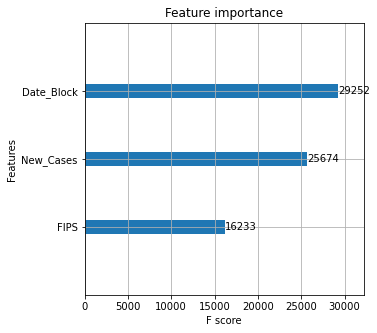

In [17]:
# Plot feature importance
plt.rcParams["figure.figsize"] = (5, 5)
plot_importance(baseline_model)